Deconvoluting spatial transcriptomics datasets with Stereoscope
===============================================================

This tutorial shows how to use **Stereoscope** for deconvolution of spatial transcriptomics data.

- [paper]( https://www.nature.com/articles/s42003-020-01247-y)
- code [1](https://docs.scvi-tools.org/en/stable/api/reference/scvi.external.RNAStereoscope.html#scvi.external.RNAStereoscope) and [2](https://docs.scvi-tools.org/en/stable/api/reference/scvi.external.SpatialStereoscope.html#scvi.external.SpatialStereoscope)
- [tutorial](https://docs.scvi-tools.org/en/stable/tutorials/notebooks/stereoscope_heart_LV_tutorial.html)

For an in-depth overview of the method, check out the scvi [user guide](https://docs.scvi-tools.org/en/stable/user_guide/models/stereoscope.html?highlight=stereoscope).

Similar (more recent) tools that solve the same problem with more advanced parametrizations are:
- [destvi](https://docs.scvi-tools.org/en/stable/user_guide/models/destvi.html?highlight=destvi)
- [cell2location](https://docs.scvi-tools.org/en/stable/tutorials/notebooks/cell2location_lymph_node_spatial_tutorial.html?highlight=cell2location#Mapping-human-lymph-node-cell-types-to-10X-Visium-with-Cell2location)

In [1]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import anndata as ad


sc.set_figure_params(figsize=(4, 4), frameon=False)

%load_ext lab_black

Set absolute path, pelase change accordingly.

In [2]:
path = pathlib.Path("/home/icb/giovanni.palla/workspace/advomics_data_spatial")

Data preparation
----------------

Read in data and standard preprocessing with Scanpy and Umap visualization.

In [3]:
sc_adata = sc.read(path / "dh_sc.h5ad")
sc_adata.var_names_make_unique()
sc.pp.subsample(sc_adata, fraction=0.5, random_state=42)
filter_clusters = sc_adata.obs.Main_cluster_name.value_counts().index.values[
    sc_adata.obs.Main_cluster_name.value_counts() > 50
]
sc_adata = sc_adata[sc_adata.obs.Main_cluster_name.isin(filter_clusters)].copy()
G = 2000
sc.pp.filter_genes(sc_adata, min_counts=10)

sc_adata.layers["counts"] = sc_adata.X.astype(np.float64).copy()
sc_adata = sc_adata[
    sc_adata.obs.Main_cluster_name != "Erythroblasts"
].copy()  # remove Erythroblasts cause they are too few
sc.pp.highly_variable_genes(
    sc_adata, n_top_genes=G, subset=True, layer="counts", flavor="seurat_v3"
)
sc.pp.normalize_total(sc_adata, target_sum=10e4)
sc.pp.log1p(sc_adata)

/home/icb/giovanni.palla/miniconda3/envs/scvi/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/icb/giovanni.palla/miniconda3/envs/scvi/lib/python3.9/site-packages/anndata/utils.py:111: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD113-1', 'SNORD113-2', 'SNORD113-3']
  warnings.warn(


/home/icb/giovanni.palla/miniconda3/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


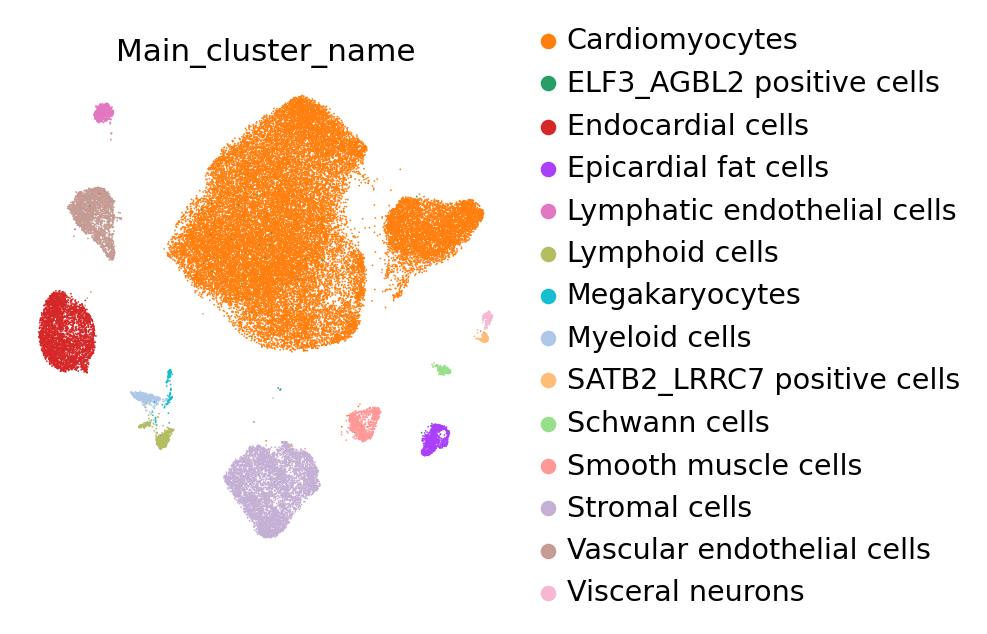

In [4]:
sc.pl.umap(sc_adata, color="Main_cluster_name")

Do the same for the spatial dataset.

In [5]:
import os

spatial_data = os.listdir(path)
spatial_data

['V10B01-014_A1.h5ad',
 'V10F24-105_B1_stereoscope.h5ad',
 'V10S28-368_D1.h5ad',
 'V10S28-371_A1_stereoscope.h5ad',
 'V10F24-105_D1_destvi.h5ad',
 'V10S28-371_A1.h5ad',
 'dh_spatial.h5ad',
 'V10F24-105_B1.h5ad',
 'V10F24-105_C1_destvi.h5ad',
 'V10F24-105_D1.h5ad',
 'V10S28-368_D1_stereoscope.h5ad',
 'dev-heart.png',
 'V10F24-105_C1_stereoscope.h5ad',
 'V10B01-014_A1_destvi.h5ad',
 'V10F24-105_D1_stereoscope.h5ad',
 'dh_sc.h5ad',
 'V10F24-105_B1_destvi.h5ad',
 'V10F24-105_A1_stereoscope.h5ad',
 'V10F24-105_C1.h5ad',
 'V10S28-368_D1_destvi.h5ad',
 'V10B01-014_A1_stereoscope.h5ad',
 'V10S28-371_A1_destvi.h5ad',
 '._dev-heart.png',
 'dev-heart_landmarks.tsv',
 '._dev-heart_landmarks.tsv',
 'V10F24-105_A1_destvi.h5ad',
 'V10F24-105_A1.h5ad']

In [6]:
[
    f
    for f in spatial_data
    if (("V1" in f) and ("destvi" not in f) and ("stereoscope" not in f))
]

['V10B01-014_A1.h5ad',
 'V10S28-368_D1.h5ad',
 'V10S28-371_A1.h5ad',
 'V10F24-105_B1.h5ad',
 'V10F24-105_D1.h5ad',
 'V10F24-105_C1.h5ad',
 'V10F24-105_A1.h5ad']

In [7]:
adatas = {}
for f in spatial_data:
    if ("V1" in f) and ("destvi" not in f) and ("stereoscope" not in f):
        adata = sc.read(path / f)
        adata.obs_names_make_unique()
        adata.var_names_make_unique()
        #         adata.layers["counts"] = adata.X.astype(np.float64).copy()
        #         sc.pp.normalize_total(adata, target_sum=10e4)
        #         sc.pp.log1p(adata)
        lib_id = f.strip(".h5ad")
        adatas[lib_id] = adata

In [8]:
adatas.keys()

dict_keys(['V10B01-014_A1', 'V10S28-368_D1', 'V10S28-371_A1', 'V10F24-105_B1', 'V10F24-105_D1', 'V10F24-105_C1', 'V10F24-105_A1'])

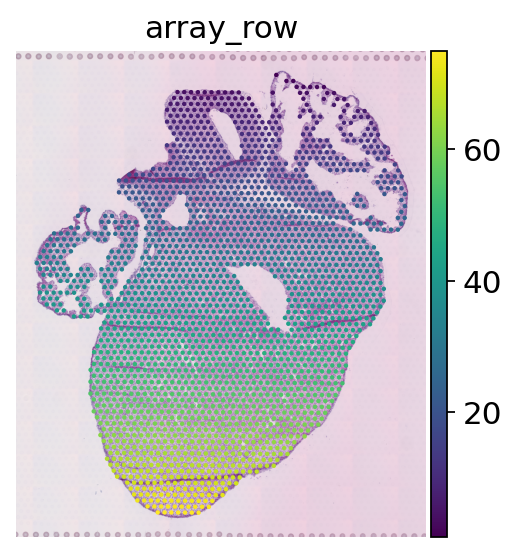

In [15]:
sc.pl.spatial(adatas["V10F24-105_C1"], color="array_row")

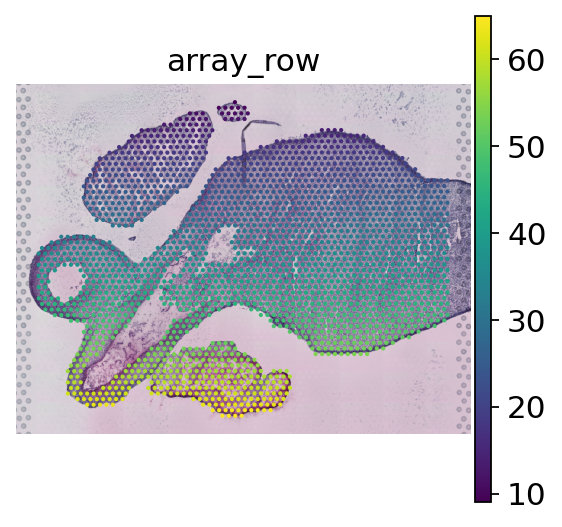

In [16]:
sc.pl.spatial(adatas["V10S28-371_A1"], color="array_row")

Find unique genes between single cell and spatial.

In [12]:
genes = list(
    set.intersection(*map(set, [adata.var_names.tolist() for adata in adatas.values()]))
)
len(genes)

10843

In [13]:
high_var_sc = sc_adata.var_names[sc_adata.var.highly_variable].tolist()

In [14]:
intersect = np.intersect1d(genes, high_var_sc)

sc_adata = sc_adata[:, intersect].copy()
for k, v in adatas.items():
    adatas[k] = v[:, intersect].copy()
G = len(intersect)

Prepare RNAStereoscope model and train.

In [17]:
from scvi.external import RNAStereoscope, SpatialStereoscope

RNAStereoscope.setup_anndata(sc_adata, layer="counts", labels_key="Main_cluster_name")

Global seed set to 0
/home/icb/giovanni.palla/miniconda3/envs/scvi/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/home/icb/giovanni.palla/miniconda3/envs/scvi/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 100/100: 100%|██████████| 100/100 [03:06<00:00,  1.82s/it, loss=1.15e+04, v_num=1]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [03:06<00:00,  1.87s/it, loss=1.15e+04, v_num=1]


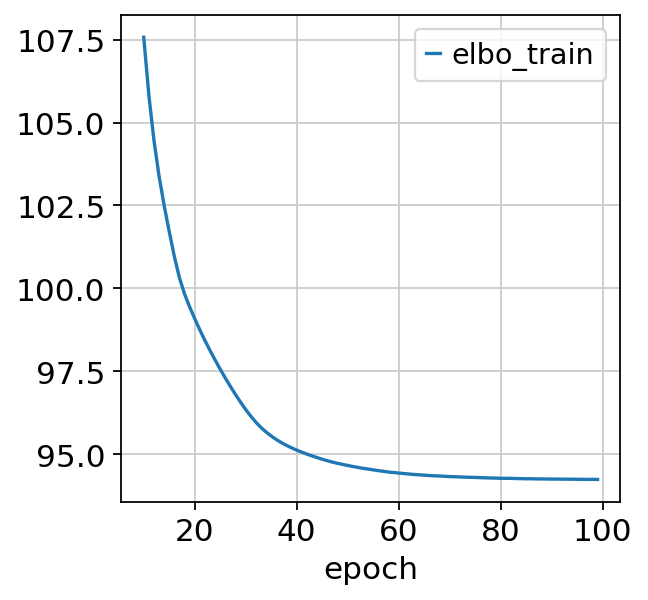

In [18]:
train = True
if train:
    sc_model = RNAStereoscope(sc_adata)
    sc_model.train(max_epochs=100, use_gpu=True)
    sc_model.history["elbo_train"][10:].plot()
    sc_model.save("scmodel", overwrite=True)
else:
    sc_model = RNAStereoscope.load("scmodel", adata=sc_adata)
    print("Loaded RNA model from file!")

Do the same for spatial model.

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1000/1000: 100%|██████████| 1000/1000 [01:59<00:00,  5.95it/s, loss=2.78e+05, v_num=1]

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 1000/1000: 100%|██████████| 1000/1000 [01:59<00:00,  8.39it/s, loss=2.78e+05, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1000/1000: 100%|██████████| 1000/1000 [01:23<00:00, 11.01it/s, loss=2.01e+05, v_num=1]

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 1000/1000: 100%|██████████| 1000/1000 [01:23<00:00, 11.95it/s, loss=2.01e+05, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1000/1000: 100%|██████████| 1000/1000 [01:43<00:00,  9.82it/s, loss=2.51e+05, v_num=1]

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 1000/1000: 100%|██████████| 1000/1000 [01:43<00:00,  9.71it/s, loss=2.51e+05, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1000/1000: 100%|██████████| 1000/1000 [01:25<00:00, 12.10it/s, loss=6.93e+05, v_num=1]

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 1000/1000: 100%|██████████| 1000/1000 [01:25<00:00, 11.64it/s, loss=6.93e+05, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1000/1000: 100%|██████████| 1000/1000 [01:47<00:00, 10.99it/s, loss=7.89e+05, v_num=1]

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 1000/1000: 100%|██████████| 1000/1000 [01:47<00:00,  9.32it/s, loss=7.89e+05, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1000/1000: 100%|██████████| 1000/1000 [01:39<00:00,  9.87it/s, loss=7.11e+05, v_num=1]

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 1000/1000: 100%|██████████| 1000/1000 [01:39<00:00, 10.09it/s, loss=7.11e+05, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1000/1000: 100%|██████████| 1000/1000 [01:34<00:00, 10.16it/s, loss=6.78e+05, v_num=1]

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 1000/1000: 100%|██████████| 1000/1000 [01:34<00:00, 10.55it/s, loss=6.78e+05, v_num=1]


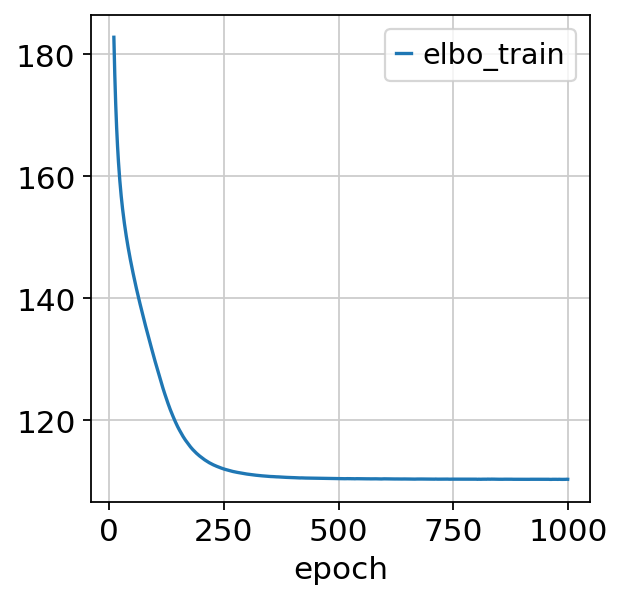

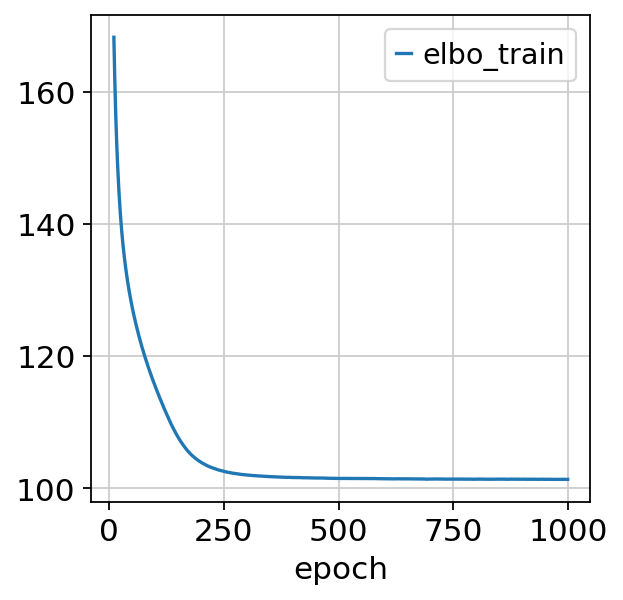

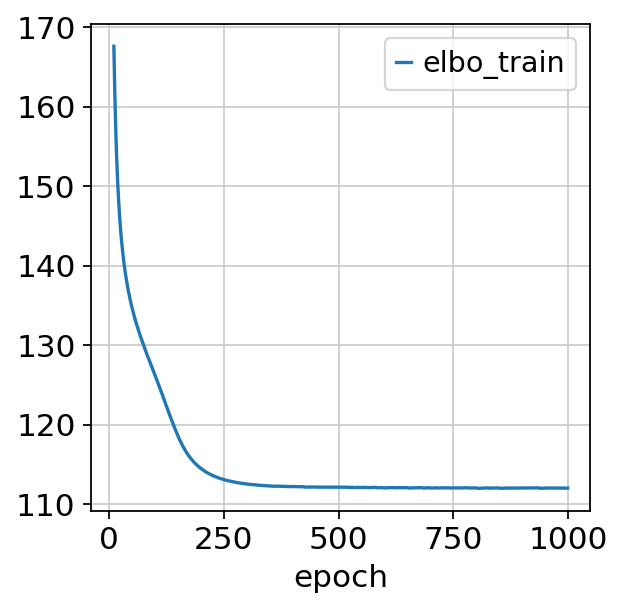

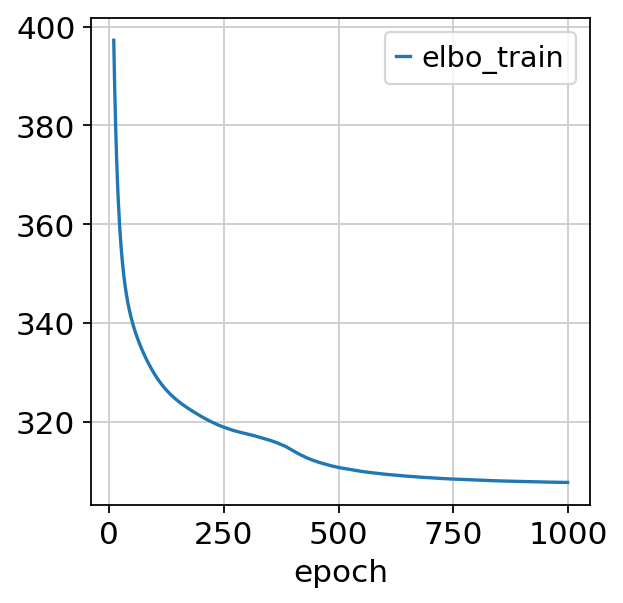

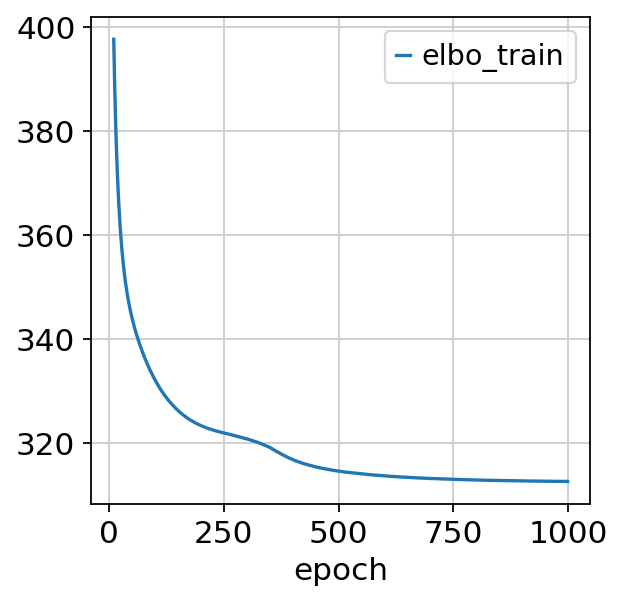

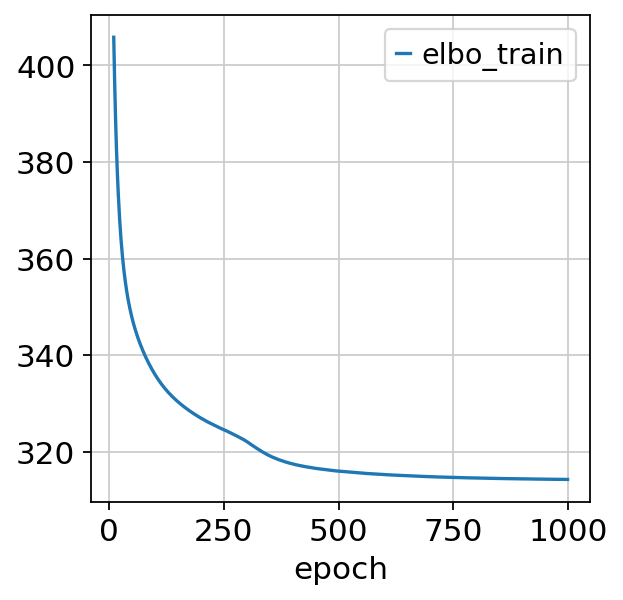

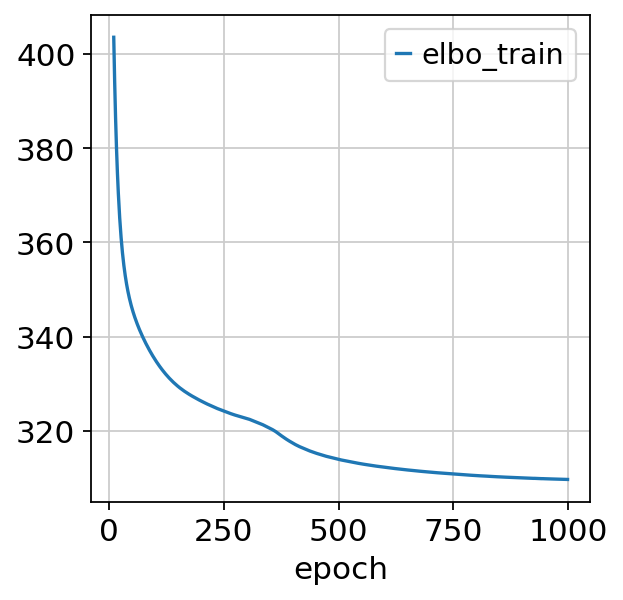

In [19]:
for k, st_adata in adatas.items():
    SpatialStereoscope.setup_anndata(st_adata, layer="counts")
    spatial_model = SpatialStereoscope.from_rna_model(
        st_adata, sc_model, layer="counts"
    )
    spatial_model.train(max_epochs=1000)
    spatial_model.history["elbo_train"][10:].plot()
    spatial_model.save("stmodel", overwrite=True)
    st_adata.obsm["deconvolution"] = spatial_model.get_proportions()
    for ct in st_adata.obsm["deconvolution"].columns:
        st_adata.obs[ct] = st_adata.obsm["deconvolution"][ct]

Visualize with Scanpy.

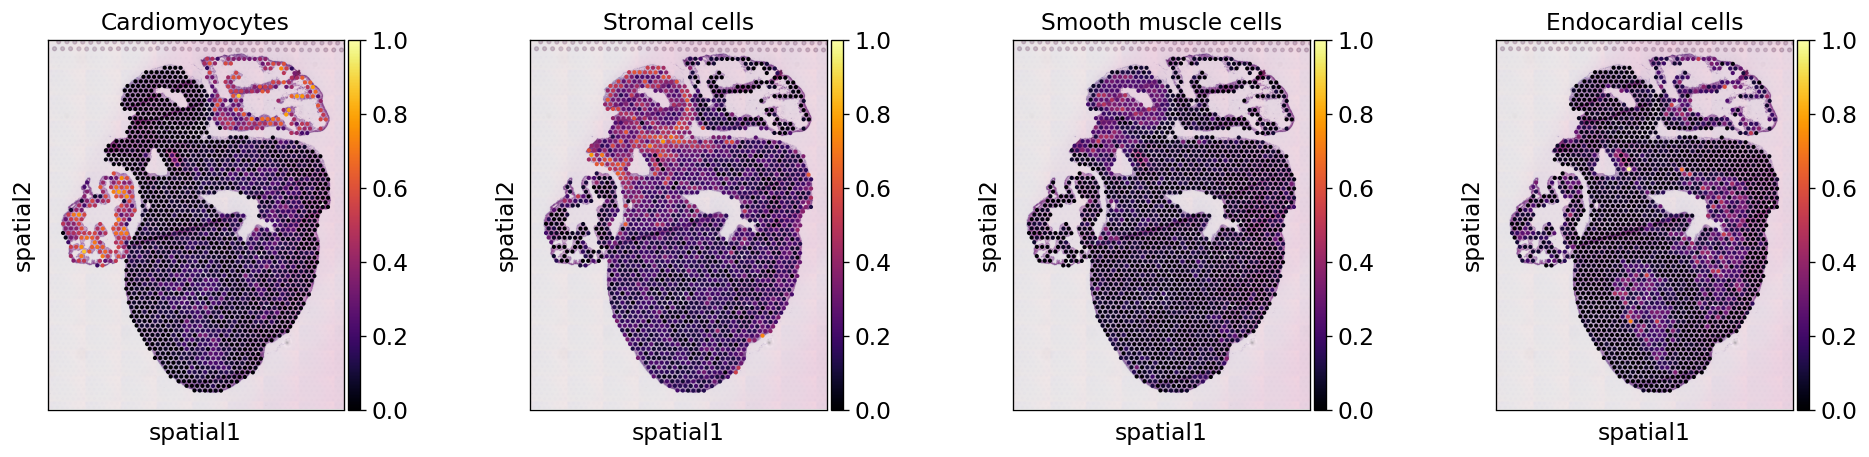

In [20]:
sc.settings.set_figure_params(
    dpi=60, color_map="RdPu", dpi_save=200, vector_friendly=True, format="svg"
)
sc.pl.spatial(
    st_adata,
    img_key="hires",
    color=[
        "Cardiomyocytes",
        "Stromal cells",
        "Smooth muscle cells",
        "Endocardial cells",
    ],
    size=1.2,
    color_map="inferno",
    vmin=0,
    vmax=1,
)

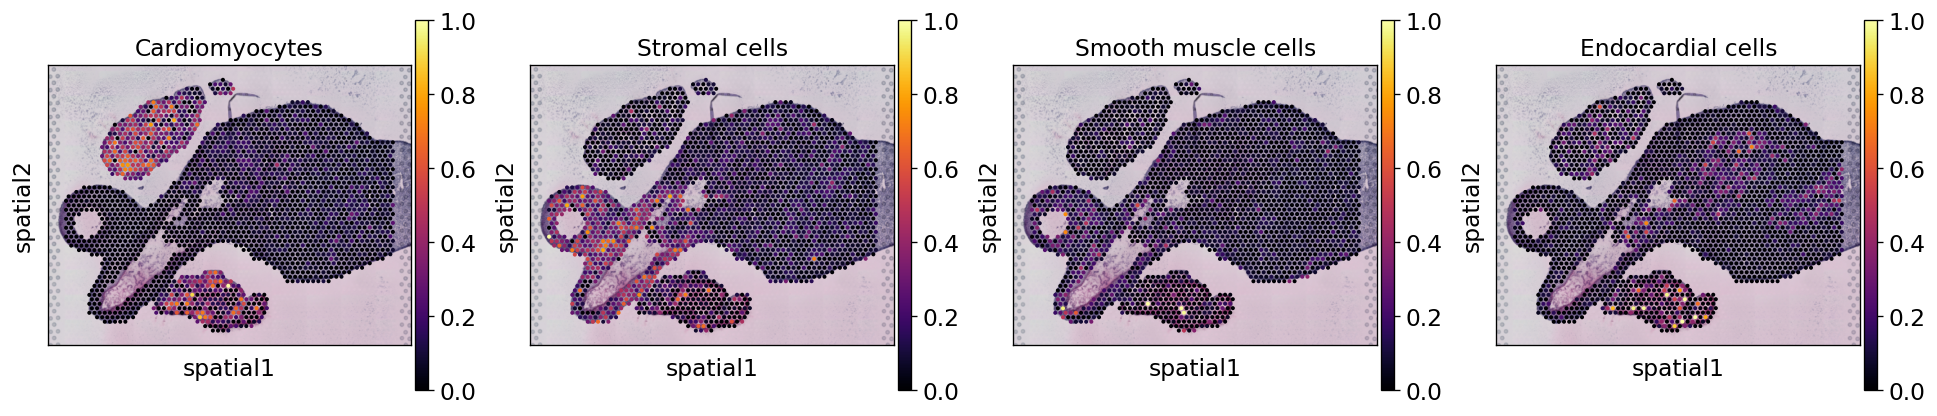

In [22]:
sc.pl.spatial(
    adatas["V10S28-371_A1"],
    img_key="lowres",
    color=[
        "Cardiomyocytes",
        "Stromal cells",
        "Smooth muscle cells",
        "Endocardial cells",
    ],
    size=1.2,
    color_map="inferno",
    vmin=0,
    vmax=1,
)

In [23]:
for k, adata in adatas.items():
    adata.write(path / f"{k}_stereoscope.h5ad")